# Open Science Prize: SWAP gate
### J. A. Montanez-Barrera and Michael R. von Spakovsky

In our approach, we use the same sequence of pulses from the default SWAP gate, a sequence of three CNOT gates and a pair of Hadamard gates in both qubits. What is different in our approach is calibration process. Instead of using a sequence of predefined gates, we use a set of random Clifford gates, which is a similar but somewhat different process from that introduced by Kelly _et. al_. [1], since we use a selective random benchmarking process for adjusting the different parameters. We use a set of random Clifford gates and vary the amplitude of the DRAG pulse in single qubits, when we get closer to the better amplitude, we increment the number of Clifford gates. In the future, we plan to use the same process of calibration for the CR amplitude and the rotary echoes of the CNOT gates.

The document is organize as follows:
- Amplitude of the Gaussian Pulse Calibration
- Amplitude of the Derivative Gaussian Pulse Calibration
- Testing using the SWAP gate 

[1] “Optimal quantum control using randomized benchmarking,” Physical Review Letters, vol. 112, no. 24, pp. 1–5, 2014.

In [14]:
import qiskit as qk
from qiskit import pulse, IBMQ
from qiskit.pulse import DriveChannel, MeasureChannel, ControlChannel
import qiskit.ignis.verification.randomized_benchmarking as rb
from qiskit.tools.monitor import job_monitor
import numpy as np
import matplotlib.pyplot as plt
from qiskit.ignis.verification import InterleavedRBFitter

import seaborn as sns
args = {"fmt":'o','capsize':3, 'elinewidth':1, 'markersize':5,'markeredgecolor':'black','markeredgewidth':0.4}
colors = sns.color_palette("husl", 8)

In [5]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science')

ibmqfactory.load_account:WARNING:2021-04-16 21:50:06,068: Credentials are already in use. The existing account in the session will be replaced.


## One-Qubit Calibration
The realization of the set of Clifford gates for "X", "Y", and "H", comes from the ideas of McKay _et. al._ [3] where we use a simple $\pi/2$ rotation about X ($RX(\pi/2)$)to calibrate these set of gates as follows: 

$$X =  RX(-\pi/2) RZ(-\pi) RX(\pi/2) RZ(-\pi) $$

$$Y =  RZ(-\pi/2) RX(-\pi/2) RZ(-\pi) RX(\pi/2) RZ(-\pi/2) $$

$$H =  RZ(-\pi/2) RX(\pi/2) RZ(-\pi/2) $$

Here, $RX(\pi/2)$ is calibrated below with a DRAG pulse.

[2] D. C. McKay, C. J. Wood, S. Sheldon, J. M. Chow, and J. M. Gambetta, “Efficient Z gates for quantum computing,” Physical Review A, vol. 96, no. 2, pp. 1–8, 2017.

In [15]:
backend = provider.get_backend('ibmq_rome')
   
backend_config = backend.configuration()
dt = backend_config.dt
backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map

cx_def = backend.defaults().instruction_schedule_map.get('cx',qubits = [0,1])


Text(0.5, 1.0, 'DRAG pulse for a RX($\\pi$/2) gate')

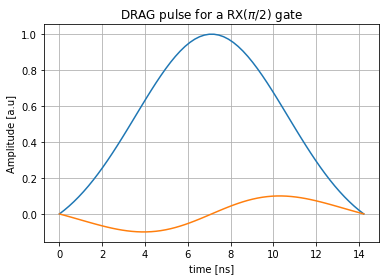

In [7]:
n = 64 # Duration in number of samples
tau = n*dt # duration in seconds
sigma = tau/4 # Parameter of the Gaussian Pulse
time = np.linspace(0,tau,n) 
Gauss = lambda t: np.exp(-0.5*((t - tau/2)/sigma)**2) # Gaussian Pulse
Gauss_trunc = lambda t: (Gauss(t) - Gauss(0))/(1 - Gauss(0)) # Truncate the Gaussian Pulse and start from zero
Samples = Gauss_trunc(time) # Samples for the gate
DGauss = lambda t: -((t - tau/2)/sigma**2)*(Gauss_trunc(t))  # Derivative of the Gaussian Pulse
DSamples = DGauss(time)/max(DGauss(time)) #Normalizing the DRAG pulse

fig, ax = plt.subplots()
ax.plot(time*1e9, Samples)
ax.plot(time*1e9, -DSamples*0.1)
ax.set_ylabel("Amplitude [a.u]")
ax.set_xlabel("time [ns]")
ax.grid()
ax.set_title(r"DRAG pulse for a RX($\pi$/2) gate")

In [8]:
DRAG = lambda amp, beta: amp*Samples + 1j*beta*DSamples

def x_gate(amp, beta, qubit=0):
    schedule = pulse.Schedule()
    schedule |= pulse.ShiftPhase(-np.pi,DriveChannel(qubit)) 
    schedule |= pulse.Play(pulse.Drag(64, amp, 64//4, beta),DriveChannel(qubit))
    schedule |= pulse.ShiftPhase(-np.pi,DriveChannel(qubit)) << schedule.duration
    schedule |= pulse.Play(pulse.Drag(64, -amp, 64//4, -beta),DriveChannel(qubit)) << schedule.duration
    return schedule
    
def y_gate(amp, beta, qubit=0):
    schedule = pulse.Schedule()
    schedule |= pulse.ShiftPhase(-np.pi/2,DriveChannel(qubit))
    schedule |= pulse.Play(pulse.Drag(64, amp, 64//4, beta),DriveChannel(qubit))
    schedule |= pulse.ShiftPhase(-np.pi,DriveChannel(qubit)) << schedule.duration 
    schedule |= pulse.Play(pulse.Drag(64, -amp, 64//4, -beta),DriveChannel(qubit)) << schedule.duration
    schedule |= pulse.ShiftPhase(-np.pi/2,DriveChannel(qubit)) << schedule.duration
    return schedule

def h_gate(amp, beta, qubit=0):
    cir = qk.QuantumCircuit(qubit+1)
    cir.h([qubit])
    cir = qk.transpile(cir, backend)
    cir_sch = qk.schedule(cir, backend)
    schedule = pulse.Schedule()
    for inst in cir_sch.instructions:
        if not isinstance(inst[1],pulse.ShiftPhase):
            schedule |= qk.pulse.Play(pulse.Drag(64, amp, 64//4, beta),DriveChannel(qubit)) << int(schedule.duration) 
        else:
            schedule |= inst[1] << schedule.duration
    return schedule

### Two-qubit calibration
After, being defined the sequence for one qubit gates, we define the two qubit gate calibration, the following code is customize for the CNOT gate between qubits 5 and 6 of the Casablanca device, because, the open-science prize specify that the improvement should be given for those qubits.

In [9]:
def cx_gate(amps, betas, qubits):
    cx = cx_def
    cx_new = pulse.Schedule()
    duration = 0
    for inst in cx.instructions:
        q = inst[1].channel.index
        if inst[1].name == "drag_31c3":
            cx_new |= x_gate(-1j*amps[q], -betas[q], q)
        elif inst[1].name == "drag_2702":
            cx_new |= pulse.Play(pulse.Drag(64, amps[q], 64//4, betas[q]),DriveChannel(q))
            duration = cx_new.duration
        elif inst[1].name == "drag_ada0":
            cx_new |= x_gate(amps[q], betas[q], q) << cx_new.duration
            duration = cx_new.duration
        else:
            cx_new |= inst[1] << duration
    return cx_new


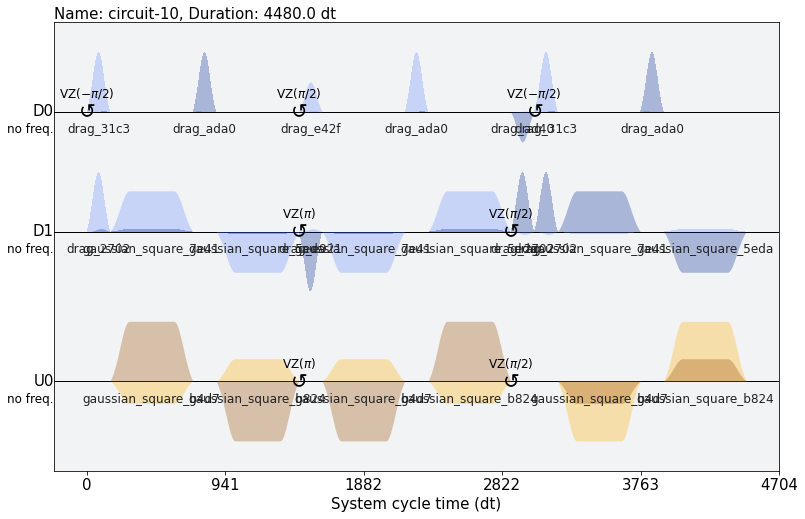

In [11]:
swap = qk.QuantumCircuit(2)
swap.swap(0,1)
swapT = qk.transpile(swap, backend)
sched = qk.schedule(swapT, backend)
sched.draw()

### Random-Benchmarking sequence Transformation
Before continuing, we need a way to transform a quantum circuit into pulses. From a set of Clifford gates in a circuit, we use the following set of functions to tranform them to pulses 

In [12]:
def set_of_gates(amps, betas):
    qubits = amps.keys()
    gates = {"x":x_gate, "y":y_gate, "h":h_gate}
    for name, gate in gates.items():
        for qubit in qubits:
            G = gate(amps[qubit], betas[qubit], qubit)
            backend.defaults().instruction_schedule_map.add(name, qubit, G)
    backend.defaults().instruction_schedule_map.add("cx",
                                                    list(qubits),
                                                    cx_gate(amps, betas, qubits))   
    
def preparing(amps, betas, circuits, opt, n):
    scheds = []
    for i in range(n):
        if opt == 0:
            set_of_gates({j:amps[j][i] for j in amps.keys()}, betas)
        elif opt == 1:
            set_of_gates(amps, {j:betas[j][i] for j in betas.keys()})
        for circuit in circuits:
            c = qk.transpile(circuit,
                             basis_gates=['u1', 'u3', 'cx', "x", "y", 'h'],
                             optimization_level=0)
            scheds += [qk.schedule(c, backend)]
    return scheds

def execute(schedules, shots=1000, meas_level=2, meas_return="avg", key="", name=""):
    if len(key) > 0:
        job = backend.retrieve_job(key)
    else:
        job = backend.run(schedules,
                          meas_level = meas_level,
                          meas_return = meas_return,
                          shots = shots,
                          qubit_lo_freq=backend_defaults.qubit_freq_est,
                          job_name=name)
        job_monitor(job)
    return job.result()

def Extract_T(result, qubits, exp, rep):
    results = {}
    for q in sorted(qubits):
        res_exp = [] 
        for i in range(exp*rep):
            counts = result.get_counts(i)    
            res_exp.append(0)
            for key in counts.keys():
                name = key[-(q+1)]
                if name == '0':
                    res_exp[i] += counts[key]
        res_exp = np.array(res_exp).reshape(exp,rep)
        results[q] = res_exp
    return results

def new_amps(amps, results, cond, n, cond2=1):
    new = {}
    for qubit, amp in amps.items():
        rang = amps[qubit][cond(np.squeeze(results[qubit].mean(axis=1)))]
        rang = rang[rang < cond2]
        new[qubit] = np.linspace(min(rang), max(rang), n)
    return new

### Experiment 1
Experiment 1 is a rough estimation of the amplitude on the qubit 0 and qubit 1 of the _ibmq_rome_ device. In this experiment, we apply only an x gate in both qubits.

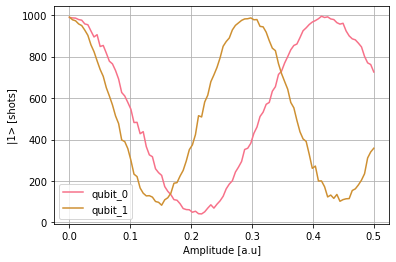

In [16]:
n0 = 100
qubits=[0,1]
cir_0 = qk.QuantumCircuit(max(qubits)+1, len(qubits))
cir_0.x([0,1])
cir_0.measure(qubits,[i for i in range(len(qubits))])
amps0 = {0:np.linspace(0, 0.5, n0),
       1:np.linspace(0, 0.5, n0)}
betas0 = {0:0,1:0}
seq0 = preparing(amps0, betas0, [cir_0], opt=0, n=n0)
result0 = execute(seq0, name="exp1", key="607a342e8bf37b0be4f36d16")

res0 = Extract_T(result0, qubits, n0, 1)
plt.figure()
plt.plot(amps0[0], res0[0], label = f"qubit_{qubits[0]}", color=colors[0])
plt.plot(amps0[1], res0[1], label = f"qubit_{qubits[1]}", color=colors[1])
plt.legend()
plt.xlabel("Amplitude [a.u]")
plt.ylabel("|1> [shots]")
plt.grid()
# plt.savefig("./Images/exp0.pdf")

### Experiment 2
In experiment 2, here, we use a random set of 50 Clifford gates with 4 seeds on qubit 0 and 1 while varying the amplitudes closed to that given in experiment 1

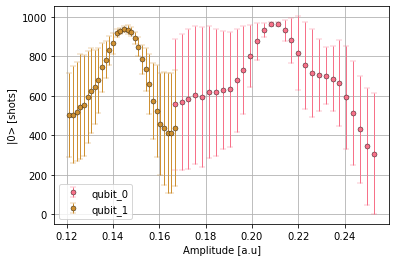

In [17]:
n1 = 30
length = 50
num_exp = 4
amps1 = new_amps(amps0, res0, lambda x: x < 150, n1, cond2=0.3)
rb1, _ = rb.randomized_benchmarking_seq(length_vector=[length],
                                            nseeds=num_exp,
                                            rb_pattern=[[i] for i in qubits])

seq1 = preparing(amps1, betas0, [rb1[i][0] for i in range(num_exp)], opt=0, n=n1)
result1 = execute(seq1, name="exp2", key="607a34a01ddf684fccae78e4")
res1 = Extract_T(result1, qubits, n1, num_exp)

plt.figure()
plt.errorbar(amps1[0], res1[0].mean(axis=1), res1[0].std(axis=1), label = f"qubit_{qubits[0]}", **args, color=colors[0])
plt.errorbar(amps1[1], res1[1].mean(axis=1), res1[1].std(axis=1), label = f"qubit_{qubits[1]}", **args, color=colors[1])
plt.legend()
plt.xlabel("Amplitude [a.u]")
plt.ylabel("|0> [shots]")
plt.grid()
# plt.savefig("./Images/exp1.pdf")

### Experiment 3
In experiment 3, we reduce the amplitude of the DRAG pulse and increase the number of Clifford gates. We update the amplitude with the experiment with the minimum standard deviation.

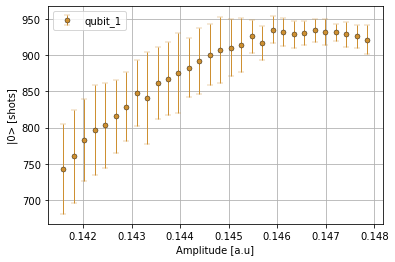

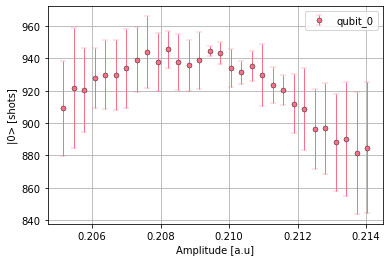

In [19]:
n5 = 30
length = 100
num_exp = 4
amps5 = new_amps(amps1, res1, lambda x: x > 900, n1)
rb5, _ = rb.randomized_benchmarking_seq(length_vector=[length],
                                            nseeds=num_exp,
                                            rb_pattern=[[i] for i in qubits])

seq5 = preparing(amps5, betas0, [rb5[i][0] for i in range(num_exp)], opt=0, n=n1)
result5 = execute(seq5, name="exp5", key="607a36d08bf37b4e70f36d39")
res5 = Extract_T(result5, qubits, n5, num_exp)

plt.figure()
plt.errorbar(amps5[1], res5[1].mean(axis=1), res5[1].std(axis=1), label = f"qubit_{qubits[1]}", **args, color=colors[1])
plt.legend()
plt.xlabel("Amplitude [a.u]")
plt.ylabel("|0> [shots]")
plt.grid()
plt.figure()
plt.errorbar(amps5[0], res5[0].mean(axis=1), res5[0].std(axis=1), label = f"qubit_{qubits[0]}", **args, color=colors[0])
plt.legend()
plt.xlabel("Amplitude [a.u]")
plt.ylabel("|0> [shots]")
plt.grid()
# plt.savefig("./Images/exp6.pdf")

### Experiment 4
In experiment 4, we use the amplitude with the maximum number of shots of state $\left|0\right>$ in experiment 2 while varying the beta value between -2 and 2 with a sequence of random Clifford gates of 100 and 3 seeds

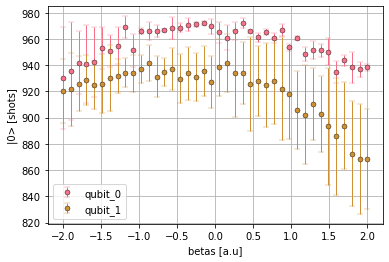

In [20]:
n2 = 40
length = 100
num_exp = 3
amps = {0:amps5[0][np.argmin(res5[0].std(axis=1))],
         1:amps5[1][np.argmin(res5[1].std(axis=1))]}
betas2 = {0:np.linspace(-2, 2, n2),
          1:np.linspace(-2, 2, n2)}

seq2 = preparing(amps, betas2, [rb1[i][0] for i in range(num_exp)], opt=1, n=n2)
result2 = execute(seq2, name="exp3", key="607a37f4ef647f5c89cd58f6")
res2 = Extract_T(result2, qubits, n2, num_exp)

plt.figure()
plt.errorbar(betas2[0], res2[0].mean(axis=1), res2[0].std(axis=1), label = f"qubit_{qubits[0]}", **args, color=colors[0])
plt.errorbar(betas2[1], res2[1].mean(axis=1), res2[1].std(axis=1), label = f"qubit_{qubits[1]}", **args, color=colors[1])
plt.legend()
plt.xlabel("betas [a.u]")
plt.ylabel("|0> [shots]")
plt.grid()

In [21]:
coupling_map = backend.configuration().coupling_map
gate_errors_cx = [backend.properties().gate_error('cx', qubit_pair) for qubit_pair in coupling_map]

for qubit_pair, gate_error_cx in zip(coupling_map, gate_errors_cx):
    print("Qubit pair {} has cx error {:.4f}".format(qubit_pair, gate_error_cx))

best_cx_error = min(gate_errors_cx)
best_qubit_pair = coupling_map[gate_errors_cx.index(min(gate_errors_cx))]
print("Best cx gate is qubit pair {} with cx error {:.4f} ({:.2f}%)".format(best_qubit_pair, best_cx_error, best_cx_error*100))


# do RB on swap gate between the qubits that have the cx gate with lowest error
q1 = best_qubit_pair[0]
q2 = best_qubit_pair[1]

# generate the RB circuit parameters
length_vector = np.arange(1,200,20)
nseeds = 5
rb_pattern = [[q1,q2]]

Qubit pair [0, 1] has cx error 0.0067
Qubit pair [1, 0] has cx error 0.0067
Qubit pair [1, 2] has cx error 0.0263
Qubit pair [2, 1] has cx error 0.0263
Qubit pair [2, 3] has cx error 0.0127
Qubit pair [3, 2] has cx error 0.0127
Qubit pair [3, 4] has cx error 0.0102
Qubit pair [4, 3] has cx error 0.0102
Best cx gate is qubit pair [0, 1] with cx error 0.0067 (0.67%)


In [22]:
qc_swap = qk.QuantumCircuit(2)

### YOUR CODE GOES HERE -- START

qc_swap.cx(0,1)
qc_swap.h([0,1])
qc_swap.cx(0,1)
qc_swap.h([0,1])
qc_swap.cx(0,1)
### YOUR CODE GOES HERE -- FINISH

interleaved_elem = [qc_swap]

In [ ]:
# Generate the RB circuits
rb_circs, xdata, circuits_interleaved = rb.randomized_benchmarking_seq(length_vector=length_vector,
                                             nseeds=nseeds,
                                             rb_pattern=rb_pattern,
                                             interleaved_elem=interleaved_elem)

# set_of_gates(amps, betas)
# Execute the non-interleaved RB circuits as a reference 
shots=1000
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
result_list1 = []
transpile_list1 = []
for rb_seed,rb_circ_seed in enumerate(rb_circs):
    print('Compiling seed %d'%rb_seed)
    rb_circ_transpile = qk.transpile(rb_circ_seed, basis_gates=basis_gates, optimization_level=0)
    print('Simulating seed %d'%rb_seed)
    # rb_circ_schedule = qk.schedule(rb_circ_transpile, backend)
    job = qk.execute(rb_circ_transpile, shots=shots, backend=backend)
    job_monitor(job)
    result_list1.append(job.result())
    transpile_list1.append(rb_circ_transpile)    
print("Finished Simulating")

In [ ]:
rbfit = rb.fitters.RBFitter(result_list1[0], xdata, rb_pattern)

for seed_num, data in enumerate(result_list1):#range(1,len(result_list)):  
    plt.figure(figsize=(6, 6))
    axis = [plt.subplot(1, 1, 1)]
    
    # Add another seed to the data
    rbfit.add_data([data])
    
    for i in range(1):
        pattern_ind = i

        # Plot the essence by calling plot_rb_data
        rbfit.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

        # Add title and label
        axis[i].set_title('2 Qubit RB - after seed %d'%(seed_num), fontsize=18)
        

In [ ]:
# Execute the interleaved RB circuits
shots=1000
interleaved_result_list1 = []
basis_gates = ['u1','u3','cx'] # use U,CX for now
interleaved_transpile_list1 = []
for rb_seed,rb_circ_seed in enumerate(circuits_interleaved):
    print('Compiling seed %d'%rb_seed)
    rb_circ_transpile = qk.transpile(rb_circ_seed, basis_gates=basis_gates, optimization_level=0)
    print('Simulating seed %d'%rb_seed)
    # rb_circ_schedule = qk.schedule(rb_circ_transpile, backend)
    job = qk.execute(rb_circ_transpile, shots=shots, backend=backend)
    job_monitor(job)
    interleaved_result_list1.append(job.result())
    interleaved_transpile_list1.append(rb_circ_transpile)    
print("Finished Simulating")

In [ ]:
# Plot the interleaved RB circuit results
rbfit = rb.fitters.RBFitter(interleaved_result_list1[0], xdata, rb_pattern)

for seed_num, data in enumerate(interleaved_result_list1):#range(1,len(result_list)):  
    plt.figure(figsize=(6, 6))
    axis = [plt.subplot(1, 1, 1)]
    
    # Add another seed to the data
    rbfit.add_data([data])
    
    for i in range(1):
        pattern_ind = i

        # Plot the essence by calling plot_rb_data
        rbfit.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

        # Add title and label
        axis[i].set_title('2 Qubit RB - after seed %d'%(seed_num), fontsize=18)

### Results
The results of our calibration approach are shown in the figure below. Here,  we cannot improve the result with the default set of gates. However, the results can be improved using more Clifford gates and reduce the amplitude range. The result with our approach gives an error of $3.21\%$. Meanwhile,  the error of the default setting was $2.56\%$

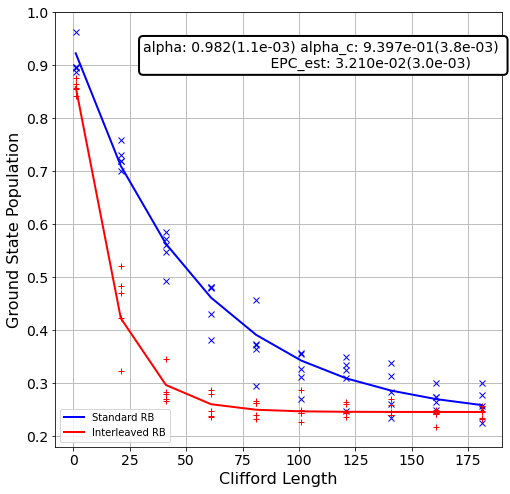

In [23]:
result_list1 = list(np.load("result_list1.npy", allow_pickle=True))
interleaved_result_list1 = list(np.load("interleaved_result.npy", allow_pickle=True))
xdata = np.load("xdata.npy", allow_pickle=True)
rb_pattern = np.load("rb_pattern.npy", allow_pickle=True)
rb_fit_interleaved = InterleavedRBFitter(result_list1, list(interleaved_result_list1), xdata, rb_pattern)
    

plt.figure(figsize=(8, 8))
axis = [plt.subplot(1, 1, 1)]
rb_fit_interleaved.plot_rb_data(ax=axis[0],add_label=True, show_plt=False)